In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml
import torch

from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule

import matplotlib.pyplot as plt

In [3]:
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes','turb_mfn_spec')
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
fig_path = base_dir / Path('figures')
res_path = base_dir / Path('results')

In [4]:
seed = 666
seed_everything(seed, workers=True)

# train
batch_size = {
    'train' : 266
,   'val'   : 266
,   'test'  : 512
}
dx = {
    'train' : 8
,   'val'   : 8
,   'test'  : 1
}
dt = {
    'train' : 8
,   'val'   : 8
,   'test'  : 8
}
nt_train = 8

run = 'moMFN'

model = {
    'name' : run
,   'cnn' : False
,   'do_divfree' : False
}

exp_suffix = f'{nt_train}x32x32'

n_epoch = 5000
hparams = {
    'name': model['name'],
    'do_time' : True,
    'do_cnn' : model['cnn'],
    'mlp_layers_num': 4,
    'mlp_layers_dim': 128, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 128,
    'rff_scale_space': 10,
    'rff_num_time': 64, 
    'rff_scale_time': 1,
    'do_divfree': model['do_divfree'],
    'lam_sdiv': 0, 
    'lam_sfn':  0,    
    'lam_spec': 0,    
    'lam_grads':0,    
    'lam_curl' :0,    
    'lam_pde' : 0,
    'lam_weight': 1e-5,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

Global seed set to 666


In [5]:
from turboflow.models.phyrff import plDivFreeRFFNet

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))
print(model)

2022-06-07 13:04:10.278777: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


plDivFreeRFFNet(
  (rff_time): Fourier()
  (rff_space): Fourier()
  (mfn): moMFN(
    (filters): ModuleList(
      (0): GaborFilter(
        (linear): Linear(in_features=3, out_features=128, bias=True)
      )
      (1): GaborFilter(
        (linear): Linear(in_features=3, out_features=128, bias=True)
      )
      (2): GaborFilter(
        (linear): Linear(in_features=3, out_features=128, bias=True)
      )
      (3): GaborFilter(
        (linear): Linear(in_features=3, out_features=128, bias=True)
      )
    )
    (linear): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=2, bias=True)
    )
    (mid_linear): ModuleList(
      (0): Linear(in_features=128, out_features=2, bias=True)
      (1): Linear(in_features=128, out_features=2, bias=True)
      (2): Linear(in_features=128, out_fe

torch.Size([128, 3])


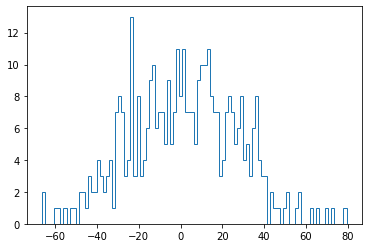

torch.Size([128, 3])


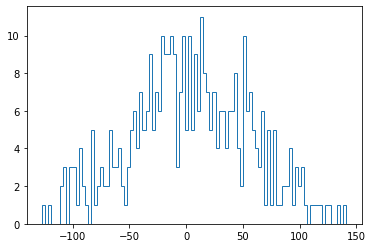

torch.Size([128, 3])


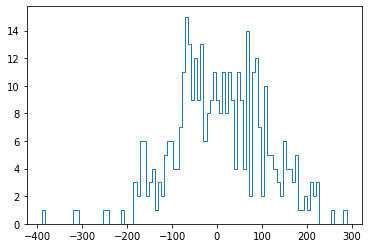

torch.Size([128, 3])


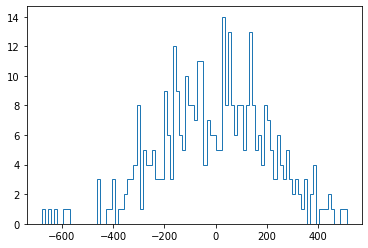

In [6]:
for k in range(4):
    w0 = model.mfn.filters[k].linear.weight.data
    print(w0.shape)
    plt.hist(w0.flatten().detach().cpu().numpy(), bins=100, histtype='step')
    plt.show()

In [7]:
# load dataset for TRAIN
dm_train = TurboFlowDataModule(
    dataset='Turb2D', 
    data_dir=data_dir,
    time_idx=np.arange(dt['train']*nt_train),

    train_batch_size=batch_size['train'],
    val_batch_size=batch_size['val'],
    test_batch_size=batch_size['test'],

    train_downsampling_space=dx['train'],
    val_downsampling_space=dx['val'],
    test_downsampling_space=dx['test'],

    train_downsampling_time=dt['train'],
    val_downsampling_time=dt['val'],
    test_downsampling_time=dt['test'],

    train_shuffle=True,
    val_shuffle=False,
    test_shuffle=False,
    num_workers=8)

dm_train.setup()

datasets = [dm_train.train_dataset, dm_train.val_dataset, dm_train.test_dataset]
for dataset in datasets:
    X, y = dataset[:]
    print(X.shape, y.shape, dataset.img_res, dataset.vars_shape_img)

torch.Size([8192, 3]) torch.Size([8192, 2]) 32 (8, 32, 32, 3)
torch.Size([8192, 3]) torch.Size([8192, 2]) 32 (8, 32, 32, 3)
torch.Size([524288, 3]) torch.Size([524288, 2]) 256 (8, 256, 256, 3)


In [8]:
early_stop_callback = EarlyStopping(
    monitor='val/loss/tot', 
    patience=3,
    min_delta=1e-5)
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/tot",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name'], exp_suffix),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(
    gpus=1,
    max_epochs=n_epoch, 
    log_every_n_steps=5,
    check_val_every_n_epoch=10, 
    callbacks=[early_stop_callback, checkpoint_callback])

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
trainer.fit(model, dm_train)
best_model_path = checkpoint_callback.best_model_path
best_model_score = checkpoint_callback.best_model_score

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | rff_time  | Fourier         | 64    
1 | rff_space | Fourier         | 256   
2 | mfn       | moMFN           | 54.7 K
3 | sp_grad   | SpatialGradient | 0     
4 | sp_lapl   | Laplacian       | 0     
----------------------------------------------
54.7 K    Trainable params
320       Non-trainable params
55.0 K    Total params
0.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 666


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
x, y = dm_train.test_dataset[:]

y = y.reshape(8,256,256,2)
plt.imshow(y[8,:,:,0].detach().cpu().numpy())

yf, yi = model.mfn(x)

In [ ]:
yf = yf.reshape(16,256,256,2)
plt.imshow(yf[8,:,:,0].detach().cpu().numpy())

In [ ]:
for y_ in yi:
    print(y_.shape)
    y_ = y_.reshape(16,256,256,2)
    plt.imshow(y_[8,:,:,0].detach().cpu().numpy())
    plt.show()

In [ ]:
x = torch.rand([1000,3]).T

plt.hist(x.flatten().numpy(), bins=100, histtype='step')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('after filter linear')
s0 = model.mfn.filters[0].linear(x)
plt.hist(s0.flatten().detach().cpu().numpy(), bins=100, histtype='step')
plt.xlim([-1.2, 1.2])

plt.subplot(122)
plt.title('after filter sine')
g0 = model.mfn.filters[0](x)
w0 = model.mfn.filters[0].linear.weight.data
plt.hist(w0.flatten().detach().cpu().numpy(), bins=100, histtype='step')
plt.show()


s0 = model.mfn.filters[0].gamma
plt.hist(s0.flatten().detach().cpu().numpy(), bins=100, histtype='step')
plt.show()

In [ ]:
# print(model)